In [4]:
# prepare_data_for_eda.py scrip, without saving out to pkl or csv
import os
import pandas as pd
import logging.config
import matplotlib.pyplot as plt
import numpy as np
from cycler import cycler #for matplotlib colors
import seaborn as sns
from sklearn import preprocessing
from sqlalchemy import create_engine
import importlib
import missingno as msno
import functions_to_derive_vars
importlib.reload(functions_to_derive_vars)

LOGGING_CONFIG = os.getenv('LOGGING_CONFIG')
logging.config.fileConfig(LOGGING_CONFIG)
logger = logging.getLogger('prepare_data_for_eda')

In [5]:
DATADIR = os.getenv('DATADIR')
logger.info("using DATADIR {}".format(DATADIR))
ENGINE = os.getenv('ENGINE')
logger.info("using data from {}".format(ENGINE))

2018-05-30 10:35:41,142 - prepare_data_for_eda - INFO - using DATADIR ../DATA
2018-05-30 10:35:41,144 - prepare_data_for_eda - INFO - using data from postgresql://ellieking@localhost:5432/givedata_180515


In [6]:
# ### Read in data
engine = create_engine(ENGINE)

logger.info('Importing facts_metrics')
facts_metrics = pd.read_sql_query('select dimensions_date_id, dimensions_item_id, pageviews, unique_pageviews, feedex_comments, is_this_useful_yes, is_this_useful_no,\
number_of_internal_searches, exits, entrances, bounce_rate,\
avg_time_on_page from "facts_metrics"',con=engine)

logger.info('Importing dates')
dates = pd.read_sql_query('select * from "dimensions_dates"',con=engine)
logger.info('Dropping {} dates duplicates'.format(sum(dates.duplicated())))
dates = dates.drop_duplicates()

2018-05-30 10:35:41,567 - prepare_data_for_eda - INFO - Importing facts_metrics
2018-05-30 10:37:57,009 - prepare_data_for_eda - INFO - Importing dates
2018-05-30 10:37:57,044 - prepare_data_for_eda - INFO - Dropping 0 dates duplicates


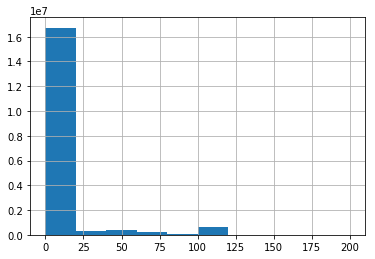

In [4]:
facts_metrics['bounce_rate'].hist()

In [7]:
logger.info('Importing items')
items = pd.read_sql_query('select id, \
content_id, title, base_path, description, number_of_pdfs, document_type, content_purpose_document_supertype,\
first_published_at, public_updated_at, number_of_word_files, status,  \
readability_score, contractions_count, equality_count, indefinite_article_count, \
passive_count, profanities_count, redundant_acronyms_count, repeated_words_count, \
simplify_count, spell_count, string_length, sentence_count, word_count, \
primary_organisation_title, primary_organisation_content_id, primary_organisation_withdrawn,\
content_hash, locale, publishing_api_payload_version from "dimensions_items"',con=engine)
logger.info('Finished importing items')

2018-05-30 10:37:57,071 - prepare_data_for_eda - INFO - Importing items
2018-05-30 10:38:03,010 - prepare_data_for_eda - INFO - Finished importing items


Something wrong with description reading in...

In [ ]:
items.description.head()

In [8]:
logger.info("create lists of component variables")
spelling_grammar_vars = ['contractions_count',
                         'indefinite_article_count',
                         'redundant_acronyms_count',
                         'repeated_words_count',
                         'spell_count'
                         ]

style_vars = ['readability_score',
              'equality_count',
              'passive_count',
              'simplify_count'
              ]

error_vars = ['profanities_count', 'spell_count']

2018-05-30 10:38:03,018 - prepare_data_for_eda - INFO - create lists of component variables


In [9]:
# ### Join facts_metrics to specific item variables

logger.info("joining facts_metrics to items")

content_performance_bytime = pd.merge(
    left=facts_metrics,
    right=items,
    left_on='dimensions_item_id', #
    right_on='id', # 
    how='outer', # keep everything for checking merge
    indicator=True # so we can filter by match type
)

logger.info("{} items(right) matches in facts_metrics(left)".format(
    content_performance_bytime.groupby('_merge').size()
    )
)


# ### Dates to index for plots
logger.info("dates to index")
content_performance_bytime['date'] = pd.to_datetime(content_performance_bytime['dimensions_date_id'])
content_performance_bytime.index = content_performance_bytime['date']

2018-05-30 10:38:03,028 - prepare_data_for_eda - INFO - joining facts_metrics to items
2018-05-30 10:39:41,641 - prepare_data_for_eda - INFO - _merge
left_only            0
right_only        4269
both          18266364
dtype: int64 items(right) matches in facts_metrics(left)
2018-05-30 10:39:41,651 - prepare_data_for_eda - INFO - dates to index


In [10]:
content_performance_bytime = functions_to_derive_vars.derive_variables(content_performance_bytime, spelling_grammar_vars, style_vars, error_vars, logger)

2018-05-30 10:39:45,277 - prepare_data_for_eda - INFO - create count_survey_responses
2018-05-30 10:39:45,661 - prepare_data_for_eda - INFO - create response_per_pageview
2018-05-30 10:39:46,050 - prepare_data_for_eda - INFO - create response_per_unique_pageview
2018-05-30 10:39:46,454 - prepare_data_for_eda - INFO - create useful_per_responses
2018-05-30 10:39:46,758 - prepare_data_for_eda - INFO - create mean_views_per_session
2018-05-30 10:39:47,034 - prepare_data_for_eda - INFO - create feedex_per_unique
2018-05-30 10:39:47,431 - prepare_data_for_eda - INFO - create searches_per_pageview
2018-05-30 10:39:47,835 - prepare_data_for_eda - INFO - Loop through and min-max scale component vars
2018-05-30 10:40:02,155 - prepare_data_for_eda - INFO - Sum component vars for each composite var
2018-05-30 10:40:04,089 - prepare_data_for_eda - INFO - spelling_grammar: count    1.827063e+07
mean     1.783485e-03
std      9.770571e-03
min      0.000000e+00
25%      1.005632e-04
50%      6.033789

In [ ]:
facts_metrics.columns

ave_time_on_page = ga:timeOnPage / (ga:pageviews - ga:exits)
bounce_rate = single-page session / sessions starting with that page

"For all sessions that start with the page, Bounce Rate is the percentage that were the only one of the session"

In [15]:
metrics_time_independent_sum = facts_metrics[['dimensions_item_id', 'pageviews', 'unique_pageviews', 'feedex_comments',
       'is_this_useful_yes', 'is_this_useful_no',
       'number_of_internal_searches', 'exits', 'entrances']].groupby('dimensions_item_id').sum()

In [16]:
metrics_time_independent_sum.describe()

,pageviews,unique_pageviews,feedex_comments,is_this_useful_yes,is_this_useful_no,number_of_internal_searches,exits,entrances
count,4.468500e+05,4.468500e+05,446850.000000,446850.000000,446850.000000,4.468500e+05,4.468500e+05,4.468500e+05
mean,8.007410e+02,5.620664e+02,0.413752,0.594025,0.491838,1.004462e+01,2.225770e+02,2.336057e+02
std,3.948670e+04,2.857576e+04,163.359843,34.601771,27.628809,2.949882e+03,1.071904e+04,9.550655e+03
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
50%,3.000000e+00,2.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,1.000000e+00,0.000000e+00
75%,2.200000e+01,1.700000e+01,0.000000,0.000000,0.000000,0.000000e+00,6.000000e+00,4.000000e+00
max,1.164198e+07,8.552308e+06,108022.000000,13895.000000,9654.000000,1.725798e+06,3.238626e+06,2.532019e+06


In [17]:
metrics_time_independent_ave = facts_metrics[['dimensions_item_id', 'bounce_rate',
       'avg_time_on_page']].groupby('dimensions_item_id').mean()

In [18]:
metrics_time_independent = pd.concat([metrics_time_independent_sum,metrics_time_independent_ave], axis=1)

In [19]:
metrics_time_independent_ave.describe()

,bounce_rate,avg_time_on_page
count,446850.000000,446850.000000
mean,6.056993,21.892345
std,13.216775,48.498664
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.837209
75%,4.651163,18.325581
max,100.000000,745.372093


In [20]:
logger.info("joining metrics_time_independent to items")

content_performance = pd.merge(
    left=metrics_time_independent,
    right=items,
    left_index=True, # dimensions_items_id
    right_on='id', # database specific key
    how='outer', # keep everything for checking merge
    indicator=True # so we can filter by match type
)

logger.info("{} items(right) matches in metrics_time_independent(left)".format(
    content_performance.groupby('_merge').size()
    )
)
logger.info("content_performance.content_id.nunique()={}".format(content_performance.content_id.nunique()))
logger.info("content_performance.id.nunique()={}".format(content_performance.id.nunique()))
logger.info("content_performance.shape={}".format(content_performance.shape))

2018-05-30 12:19:32,626 - prepare_data_for_eda - INFO - joining metrics_time_independent to items
2018-05-30 12:19:36,186 - prepare_data_for_eda - INFO - _merge
left_only          0
right_only      4269
both          446850
dtype: int64 items(right) matches in metrics_time_independent(left)
2018-05-30 12:19:36,474 - prepare_data_for_eda - INFO - content_performance.content_id.nunique()=428739
2018-05-30 12:19:36,511 - prepare_data_for_eda - INFO - content_performance.id.nunique()=451119
2018-05-30 12:19:36,512 - prepare_data_for_eda - INFO - content_performance.shape=(451119, 42)


For each content item, there may be multiple ids because each time an item is edited it receives a new ID

In [21]:
content_performance = functions_to_derive_vars.derive_variables(content_performance, spelling_grammar_vars, style_vars, error_vars, logger)

2018-05-30 12:19:36,519 - prepare_data_for_eda - INFO - create count_survey_responses
2018-05-30 12:19:36,525 - prepare_data_for_eda - INFO - create response_per_pageview
2018-05-30 12:19:36,530 - prepare_data_for_eda - INFO - create response_per_unique_pageview
2018-05-30 12:19:36,536 - prepare_data_for_eda - INFO - create useful_per_responses
2018-05-30 12:19:36,542 - prepare_data_for_eda - INFO - create mean_views_per_session
2018-05-30 12:19:36,548 - prepare_data_for_eda - INFO - create feedex_per_unique
2018-05-30 12:19:36,554 - prepare_data_for_eda - INFO - create searches_per_pageview
2018-05-30 12:19:36,560 - prepare_data_for_eda - INFO - Loop through and min-max scale component vars
2018-05-30 12:19:36,706 - prepare_data_for_eda - INFO - Sum component vars for each composite var
2018-05-30 12:19:36,737 - prepare_data_for_eda - INFO - spelling_grammar: count    451119.000000
mean          0.001872
std           0.009989
min           0.000000
25%           0.000101
50%         

In [ ]:
del items, facts_metrics, metrics_time_independent_ave, metrics_time_independent_sum

# MISSING DATA FROM MISMATCHES

### Remove editions with no data

In [22]:
content_performance = content_performance[content_performance['_merge']=='both'].copy()

In [23]:
dict(zip(list(content_performance),[content_performance[x].dtype.name for x in content_performance]))

{'pageviews': 'float64',
 'unique_pageviews': 'float64',
 'feedex_comments': 'float64',
 'is_this_useful_yes': 'float64',
 'is_this_useful_no': 'float64',
 'number_of_internal_searches': 'float64',
 'exits': 'float64',
 'entrances': 'float64',
 'bounce_rate': 'float64',
 'avg_time_on_page': 'float64',
 'id': 'int64',
 'content_id': 'object',
 'title': 'object',
 'base_path': 'object',
 'description': 'object',
 'number_of_pdfs': 'float64',
 'document_type': 'object',
 'content_purpose_document_supertype': 'object',
 'first_published_at': 'datetime64[ns]',
 'public_updated_at': 'datetime64[ns]',
 'number_of_word_files': 'float64',
 'status': 'object',
 'readability_score': 'float64',
 'contractions_count': 'float64',
 'equality_count': 'float64',
 'indefinite_article_count': 'float64',
 'passive_count': 'float64',
 'profanities_count': 'float64',
 'redundant_acronyms_count': 'float64',
 'repeated_words_count': 'float64',
 'simplify_count': 'float64',
 'spell_count': 'float64',
 'string_

In [ ]:
content_performance.columns

In [ ]:
content_performance_bytime.columns

In [ ]:
content_performance_bytime.dimensions_date_id.min()

In [11]:
content_performance_bytime = content_performance_bytime[content_performance_bytime['_merge']=='both'].copy()

In [13]:
dtypes_bytime = dict(zip(list(content_performance_bytime),[content_performance_bytime[x].dtype.name for x in content_performance_bytime]))

In [14]:
dtypes_bytime

{'dimensions_date_id': 'object',
 'dimensions_item_id': 'float64',
 'pageviews': 'float64',
 'unique_pageviews': 'float64',
 'feedex_comments': 'float64',
 'is_this_useful_yes': 'float64',
 'is_this_useful_no': 'float64',
 'number_of_internal_searches': 'float64',
 'exits': 'float64',
 'entrances': 'float64',
 'bounce_rate': 'float64',
 'avg_time_on_page': 'float64',
 'id': 'int64',
 'content_id': 'object',
 'title': 'object',
 'base_path': 'object',
 'description': 'object',
 'number_of_pdfs': 'float64',
 'document_type': 'object',
 'content_purpose_document_supertype': 'object',
 'first_published_at': 'datetime64[ns]',
 'public_updated_at': 'datetime64[ns]',
 'number_of_word_files': 'float64',
 'status': 'object',
 'readability_score': 'float64',
 'contractions_count': 'float64',
 'equality_count': 'float64',
 'indefinite_article_count': 'float64',
 'passive_count': 'float64',
 'profanities_count': 'float64',
 'redundant_acronyms_count': 'float64',
 'repeated_words_count': 'float64',

In [ ]:
timeit.timeit(content_performance.to_csv(os.path.join(DATADIR, 'content_performance.csv.gz'),  compression='gzip'))

In [ ]:
%timeit content_performance[:10].to_csv(os.path.join('..', DATADIR, 'content_performance.csv.gz'),  compression='gzip')

In [ ]:
%timeit content_performance_bytime[:10].to_csv(os.path.join('..', DATADIR, 'content_performance.csv.gz'),  compression='gzip')

In [ ]:
%timeit content_performance[:10].to_pickle(os.path.join('..', DATADIR, 'content_performance.pkl.compress'),  compression='xz')

In [ ]:
%timeit content_performance_bytime[:10].to_pickle(os.path.join('..', DATADIR, 'content_performance.pkl.compress'),  compression='xz')

In [ ]:
import tables
%timeit content_performance.to_hdf(os.path.join('..', DATADIR, 'content_performance.hdf'), 'test', mode='w')

In [1]:
dtypes_bytime

NameError: name 'dtypes_bytime' is not defined

### duplicates?

In [ ]:
content_performance.duplicated().sum()

In [ ]:
content_performance_bytime.duplicated().sum()

In [ ]:
# content_performance_bytime = content_performance_bytime.drop_duplicates().copy()

In [ ]:
logger.info("content_performance.content_id.nunique()={}".format(content_performance.content_id.nunique()))
logger.info("content_performance.id.nunique()={}".format(content_performance.id.nunique()))
logger.info("content_performance.shape={}".format(content_performance.shape))

In [ ]:
logger.info("content_performance_bytime.content_id.nunique()={}".format(content_performance_bytime.content_id.nunique()))
logger.info("content_performance_bytime.id.nunique()={}".format(content_performance_bytime.id.nunique()))
logger.info("content_performance_bytime.shape={}".format(content_performance_bytime.shape))

### Explore missing

In [ ]:
msno.matrix(content_performance[['pageviews',
       'unique_pageviews', 'feedex_comments', 'is_this_useful_yes',
       'is_this_useful_no', 'number_of_internal_searches', 'exits',
       'entrances', 'bounce_rate', 'avg_time_on_page', 'id', 'content_id',
       'title', 'base_path', 'description', 'number_of_pdfs', 'document_type',
       'content_purpose_document_supertype', 'first_published_at',
       'public_updated_at', 'number_of_word_files', 'status',
       'readability_score', 'contractions_count', 'equality_count',
       'indefinite_article_count', 'passive_count', 'profanities_count',
       'redundant_acronyms_count', 'repeated_words_count', 'simplify_count',
       'spell_count', 'string_length', 'sentence_count', 'word_count',
       'primary_organisation_title', 'primary_organisation_content_id',
       'primary_organisation_withdrawn', 'content_hash', 'locale',
       'publishing_api_payload_version', 
       'count_survey_responses', 'response_per_pageview',
       'response_per_unique_pageview', 'useful_per_responses',
       'total_to_unique_pageviews', 'feedex_per_unique_1000',
       'searches_per_pageview_1000']].sample(3000))

In [ ]:
msno.heatmap(content_performance)

In [ ]:
content_performance['description'].head()


In [ ]:
content_performance['useful_per_responses'].head()


In [ ]:
content_performance['is_this_useful_yes'].head()


In [ ]:
content_performance['count_survey_responses'].head()


In [ ]:
#msno.dendrogram(content_performance)

In [ ]:
# msno.matrix(content_performance_bytime.sample(1000), freq='D')

# Exploratory data analyses
1. Date of metric by fact, by document type/primary org (e.g., page views over date-dimension stratified by document type)
2. content-specific performance metric (e.g. reading age) by user-related performance metric (e.g., page views) over a defined time-period (min-max in date dimension)

### Dates to index for plots

In [ ]:
content_performance_bytime.index

# Intrinsic content performance metrics
Explore those metrics generated by characteristics of the content itself and their correlation with metrics relating to user interaction with content.

## Individual distributions

In [ ]:
content_performance.columns

#### Content versions (could be multiple versions of a page) with survey responses

In [ ]:
content_performance.content_id.nunique()

In [ ]:
content_performance.id.nunique()

### Histograms

In [ ]:
ga_vars = content_performance[['pageviews', 
                  'unique_pageviews', 
                  'feedex_comments', 
                  'is_this_useful_yes',
                               'is_this_useful_no',
                  'number_of_internal_searches','exits', 'entrances', 'bounce_rate', 
                  'count_survey_responses',
                  'response_per_pageview', 
                  'response_per_unique_pageview',
                  'useful_per_responses', 
                  'total_to_unique_pageviews',
                               'feedex_per_unique_1000'
                 ]].replace([np.inf, -np.inf], np.nan)
spell_grammar_vars = content_performance[[
                  'readability_score', 
                  'contractions_count', 
                  'equality_count',
                  'indefinite_article_count', 
                  'passive_count', 
                  'profanities_count',
                  'redundant_acronyms_count', 
                  'repeated_words_count', 
                  'simplify_count',
                  'spell_count',  
                 ]].replace([np.inf, -np.inf], np.nan)
content_vars = content_performance[[ 
                  'number_of_pdfs', 
                  'number_of_word_files',
                  'string_length', 
                  'sentence_count', 
                  'word_count'
                 ]].replace([np.inf, -np.inf], np.nan)

all_content_vars = content_performance[[ 'pageviews', 
                                        'unique_pageviews', 
                                        'feedex_comments',
                                        'is_this_useful_yes', 
                                        'is_this_useful_no',
                                        'number_of_internal_searches', 'exits', 'entrances', 'bounce_rate', 
                                        'number_of_pdfs', 
                                        'document_type', 
                                        'content_purpose_document_supertype',
                                        'first_published_at', 
                                        'public_updated_at', 
                                        'number_of_word_files',
                                        'status',                                          
                                        'string_length', 
                                        'sentence_count', 
                                        'word_count',
                                        'primary_organisation_content_id',
                                        'locale',
                                        'publishing_api_payload_version', 
                                        'count_survey_responses',
                                        'response_per_pageview', 
                                        'response_per_unique_pageview',
                                        'useful_per_responses', 
                                        'total_to_unique_pageviews',
                                        'feedex_per_unique_1000', 
                                        'searches_per_pageview_1000',
                                        'contractions_count_scaled', 
                                        'indefinite_article_count_scaled',
                                        'redundant_acronyms_count_scaled', 
                                        'repeated_words_count_scaled',
                                        'spell_count_scaled', 
                                        'readability_score_scaled',
                                        'equality_count_scaled', 
                                        'passive_count_scaled',
                                        'simplify_count_scaled', 
                                        'profanities_count_scaled', 
                                        'spelling_grammar',
                                        'style', 
                                        'errors'
                                       ]].replace([np.inf, -np.inf], np.nan)

composite_vars = content_performance[['spelling_grammar',
                                        'style', 
                                        'errors'
                                       ]].replace([np.inf, -np.inf], np.nan)

In [ ]:
# calculate the correlation matrix
corr_all = all_content_vars.corr()

# # plot the heatmap
# sns.heatmap(corr, 
#         xticklabels=corr.columns,
#         yticklabels=corr.columns)
fig, ax = plt.subplots(figsize=(15, 15))
mask = np.zeros_like(corr_all)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr_all, mask=mask, square=True, cmap="YlGnBu")

In [ ]:
# calculate the correlation matrix
corr_all['bounce_rate'].sort_values(ascending=False)

In [ ]:
sns.pairplot(all_content_vars, vars=['pageviews', 
                                        'unique_pageviews',
                                         'bounce_rate', 
                                        'number_of_pdfs', 
                                        'number_of_word_files',                                     
                                        'string_length', 
                                        'sentence_count', 
                                        'word_count',
                                        'count_survey_responses',
                                        'response_per_pageview', 
                                        'response_per_unique_pageview',
                                        'useful_per_responses', 
                                        'total_to_unique_pageviews',
                                        'feedex_per_unique_1000', 
                                        'searches_per_pageview_1000',
                                        'contractions_count_scaled', 
                                        'indefinite_article_count_scaled',
                                        'redundant_acronyms_count_scaled', 
                                        'repeated_words_count_scaled',
                                        'spell_count_scaled', 
                                        'readability_score_scaled',
                                        'equality_count_scaled', 
                                        'passive_count_scaled',
                                        'simplify_count_scaled', 
                                        'profanities_count_scaled', 
                                        'spelling_grammar',
                                        'style', 
                                        'errors'], hue='content_purpose_document_supertype')

In [ ]:
# calculate the correlation matrix
corr = ga_vars.corr()

# # plot the heatmap
# sns.heatmap(corr, 
#         xticklabels=corr.columns,
#         yticklabels=corr.columns)

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, square=True, cmap="YlGnBu")

In [ ]:
# calculate the correlation matrix
corr_sg = spell_grammar_vars.corr()

# # plot the heatmap
# sns.heatmap(corr_sg, 
#         xticklabels=corr_sg.columns,
#         yticklabels=corr_sg.columns)

mask = np.zeros_like(corr_sg)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr_sg, mask=mask, square=True, cmap="YlGnBu")

In [ ]:
# calculate the correlation matrix
corr_content = content_vars.corr()

# # plot the heatmap
# sns.heatmap(corr_content, 
#         xticklabels=corr_content.columns,
#         yticklabels=corr_content.columns)

mask = np.zeros_like(corr_content)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr_content, mask=mask, square=True, cmap="YlGnBu")

### proportion zero

In [ ]:
unscaled_content_vars = content_performance[[ 'pageviews', 
                                        'unique_pageviews', 
                                        'feedex_comments',
                                        'is_this_useful_yes', 
                                        'is_this_useful_no',
                                        'number_of_internal_searches','exits', 'entrances', 'bounce_rate', 
                                        'number_of_pdfs',                                 
                                        'number_of_word_files',                                        
                                        'string_length', 
                                        'sentence_count', 
                                        'word_count',
                                        'count_survey_responses',
                                        'response_per_pageview', 
                                        'response_per_unique_pageview',
                                        'useful_per_responses', 
                                        'total_to_unique_pageviews',
                                        'feedex_per_unique_1000', 
                                        'searches_per_pageview_1000',
                                        'contractions_count', 
                                        'indefinite_article_count',
                                        'redundant_acronyms_count', 
                                        'repeated_words_count',
                                        'spell_count', 
                                        'readability_score',
                                        'equality_count', 
                                        'passive_count',
                                        'simplify_count', 
                                        'profanities_count', 
                                        'spelling_grammar',
                                        'style', 
                                        'errors'
                                       ]].replace([np.inf, -np.inf], np.nan)

In [ ]:
percent_zero = unscaled_content_vars[unscaled_content_vars == 0].count(axis=0)/len(unscaled_content_vars.index)*100

In [ ]:
percent_zero.sort_values(ascending=False).plot(kind = 'barh', figsize=(12, 12), color='#2B8CC4', title='Percent of content editions where count/score is zero')

In [ ]:
ga_vars.describe()

In [ ]:
ga_vars.pageviews.describe()

In [ ]:
np.log(18)

In [ ]:
np.exp(15)

In [ ]:
ga_vars.boxplot(rot=90)

In [ ]:
sns.boxplot(data=ga_vars)

In [ ]:
ga_vars.hist(bins=100, figsize=(30, 25))

In [ ]:
ga_vars['bounce_rate'].hist(bins=20, figsize=(12, 10))

In [ ]:
np.log(ga_vars['bounce_rate']+1).hist(bins=20, figsize=(5, 5), grid=False)

In [ ]:
composite_vars.hist(bins=100, figsize=(10, 10))

In [ ]:
content_vars.hist(bins=100, figsize=(30, 30))

In [ ]:
spell_grammar_vars.hist(bins=100, figsize=(30, 30))

In [ ]:
ga_vars['pageviews'].hist(bins=50)
plt.xticks(rotation=90)

In [ ]:
ga_vars.boxplot(column='pageviews', by=None, ax=None, fontsize=None, rot=0, grid=True, figsize=None, layout=None, return_type=None)

In [ ]:
ga_vars['pageviews'].hist(bins=50, range=(0, 100), grid=False, figsize=(5, 5))
plt.xticks(rotation=90)

In [ ]:
ga_vars['pageviews'].hist(bins=50, range=(0, 1))
plt.xticks(rotation=90)

In [ ]:
log_transformed = (ga_vars['pageviews']+1).apply(np.log)

log_transformed.hist(bins=100)

In [ ]:
np.log(1)

In [ ]:

sqrt_transformed = ga_vars['pageviews'].apply(np.sqrt) # Get the square root of data points*

sqrt_transformed.hist(     # Plot histogram
                 bins=100)

In [ ]:
#    'status',  'document_type', 'content_purpose_document_supertype',
#        'first_published_at', 'public_updated_at', 'primary_organisation_title', 
#                   'locale',

In [ ]:
content_performance[content_performance['count_survey_responses']>0].shape

In [ ]:
content_performance[content_performance['count_survey_responses']==0].shape

In [ ]:
content_performance[content_performance['count_survey_responses']>0].shape[0] + content_performance[content_performance['count_survey_responses']==0].shape[0]

In [ ]:
content_performance[content_performance['count_survey_responses'].isnull()].shape[0] + \
content_performance[content_performance['count_survey_responses']>0].shape[0] + \
content_performance[content_performance['count_survey_responses']==0].shape[0]

In [ ]:
print("{} out of {} ({}%) versions of pages have at least 1 survey response".format(
    content_performance[content_performance['count_survey_responses']>0].shape[0], 
    content_performance.id.nunique(), 
    content_performance[content_performance['count_survey_responses']>0].shape[0]/ 
    content_performance.id.nunique()*100
                                                                                   ))

#### Useful_per_response

In [ ]:
content_performance.useful_per_responses.describe()

In [ ]:
(content_performance['useful_per_responses']*100).hist(bins=100, range=(0, 100))
plt.title('Percent of respondents who found edition useful')

In [ ]:
content_performance[content_performance['count_survey_responses']>1000].shape

In [ ]:
def estimate_sample_size(p_hat, z, accuracy):
    n = (p_hat*(1-p_hat)*z**2)/accuracy**2
    print ("Estimating the required sample size to estimate a proportion within {}% \n given our uninformative estimate of {}%, making this a conservative n".format(accuracy*100, p_hat*100, ))
    return n

In [ ]:
estimate_sample_size(0.5, 1.96, 0.1)

In [ ]:
accurate_proportions = content_performance[content_performance['count_survey_responses']>100]

In [ ]:
accurate_proportions.shape

In [ ]:
accurate_proportions.shape[0]/content_performance.id.nunique()*100

In [ ]:
content_performance.id.nunique()

In [ ]:
accurate_proportions.id.nunique()

In [ ]:
accurate_proportions.shape[0]/sum(content_performance['count_survey_responses']>0)*100

In [ ]:
sum(content_performance['count_survey_responses']>0)

In [ ]:
(accurate_proportions['useful_per_responses']*100).hist(bins=100, range=(0, 100), grid=False)
plt.title('Percent of respondents who found edition useful')

In [ ]:
#accurate_proportions.to_csv(os.path.join(DATADIR, 'accurate_proportions.csv.gz'), compression='gzip')
accurate_proportions.to_csv('../DATA/accurate_proportions.csv')

#### responses_per_pageview

In [ ]:
content_performance = content_performance.replace([np.inf, -np.inf], np.nan).copy()

In [ ]:
content_performance.response_per_pageview.describe()

In [ ]:
content_performance[content_performance['response_per_unique_pageview']>1]

Can't yet explain why these items were only viewed once but have 5 survey responses. 
Concerning regarding the denominator!

In [ ]:
plt.scatter(content_performance.pageviews,  content_performance.count_survey_responses, alpha=0.2)
plt.title("proportion of responses by pageviews")
plt.xlabel('pageviews')
plt.ylabel('responses')

In [ ]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(content_performance.pageviews, content_performance.count_survey_responses)

In [ ]:
plt.plot(content_performance.pageviews, content_performance.count_survey_responses, 'o', label='original data', alpha=0.2)
plt.title("proportion of responses by pageviews")
plt.xlabel('pageviews')
plt.ylabel('responses')
plt.plot(content_performance.pageviews, intercept + slope*content_performance.pageviews, 'r', label='fitted line')
plt.legend()
plt.show()

In [ ]:
plt.plot(content_performance.string_length, content_performance.response_per_pageview, 'o', label='original data', alpha=0.2)
plt.title("response rate by string length")
plt.xlabel('string_length')
plt.ylabel('response rate (per pageview)')

In [ ]:
import statsmodels.api as sm
glm_poisson = sm.GLM(content_performance.count_survey_responses,content_performance.pageviews, family=sm.families.Poisson())
res = glm_poisson.fit()
print(res.summary())

In [ ]:
# nobs = res.nobs
# # y = data.endog[:,0]/data.endog.sum(1)
# yhat = res.mu

In [ ]:
# from statsmodels.graphics.api import abline_plot

In [ ]:
# fig, ax = plt.subplots()
# ax.scatter(yhat, content_performance.count_survey_responses)
# line_fit = sm.OLS(content_performance.count_survey_responses, sm.add_constant(yhat, prepend=True)).fit()
# abline_plot(model_results=line_fit, ax=ax)


# ax.set_title('Model Fit Plot')
# ax.set_ylabel('Observed values')
# ax.set_xlabel('Fitted values')

In [ ]:
plt.scatter(content_performance.pageviews,  content_performance.useful_per_responses, alpha=0.2)
plt.title("proportion of responses by pageviews")
plt.xlabel('pageviews')
plt.ylabel('p(responses)')

In [ ]:
plt.scatter(content_performance.count_survey_responses,  content_performance.useful_per_responses, alpha=0.2)
plt.title("proportion of repsondents who found page useful by responses")

In [ ]:
plt.scatter(content_performance.pageviews,  content_performance.useful_per_responses, alpha=0.2)
plt.title("proportion of repsondents who found page useful by pageviews")

In [ ]:
# normal values
plt.figure(figsize=(7, 5))
# plt.text(0, 0, "taxons with no content in dev set", color='red', horizontalalignment='center', 
#          verticalalignment='bottom')
plt.xlabel('responses')
plt.ylabel('proportion useful')
plt.scatter(content_performance.count_survey_responses[content_performance['useful_per_responses']>=0.5],  
                                                       content_performance.useful_per_responses[content_performance['useful_per_responses']>=0.5], 
                                                                                                c = 'b',
                                                                                                alpha=0.2, 
                                                                                                )
# less than 0.8
plt.scatter(content_performance.count_survey_responses[content_performance['useful_per_responses']<0.5 ],  
                                                       content_performance.useful_per_responses[content_performance['useful_per_responses']<0.5], 
                                                                                                c = 'red',
                                                                                                alpha=0.2, 
                                                                                                )


plt.title("proportion of repsondents who found page useful by responses")

# for label, x, y in zip(dev_metrics['taxon2label'], dev_metrics['support'], dev_metrics['f1']):
#     if ((x>300 and y<0.8) or (x>1000)):
#         plt.annotate(
#             label,
#             xy=(x, y), xytext=(-1, 1),
#             textcoords='offset points', ha='right', va='bottom')
#     if (y==1):
#         label = ""
#         plt.annotate(
#             label,
#             xy=(x, y), xytext=(-1, 1),
#             textcoords='offset points', ha='right', va='bottom')

In [ ]:
# normal values
plt.figure(figsize=(7, 5))
# plt.text(0, 0, "taxons with no content in dev set", color='red', horizontalalignment='center', 
#          verticalalignment='bottom')
plt.xlabel('pageviews')
plt.ylabel('proportion useful')
plt.scatter(content_performance.pageviews[(content_performance['useful_per_responses']>=0.5) & (content_performance['pageviews']>1)],  
                                                       content_performance.useful_per_responses[(content_performance['useful_per_responses']>=0.5)  & (content_performance['pageviews']>1)], 
                                                                                                c = 'b',
                                                                                                alpha=0.2, 
                                                                                                )
# less than 0.8
plt.scatter(content_performance.pageviews[(content_performance['useful_per_responses']<0.5 ) & (content_performance['pageviews']>1)],  
                                                       content_performance.useful_per_responses[(content_performance['useful_per_responses']<0.5) & (content_performance['pageviews']>1)], 
                                                                                                c = 'red',
                                                                                                alpha=0.2, 
                                                                                                )




plt.title("proportion of repsondents who found page useful by pageviews \n(for pages with at least one view)")

plt.xticks(rotation=90)

# for label, x, y in zip(dev_metrics['taxon2label'], dev_metrics['support'], dev_metrics['f1']):
#     if ((x>300 and y<0.8) or (x>1000)):
#         plt.annotate(
#             label,
#             xy=(x, y), xytext=(-1, 1),
#             textcoords='offset points', ha='right', va='bottom')
#     if (y==1):
#         label = ""
#         plt.annotate(
#             label,
#             xy=(x, y), xytext=(-1, 1),
#             textcoords='offset points', ha='right', va='bottom')

In [ ]:
# normal values
plt.figure(figsize=(7, 5))
# plt.text(0, 0, "taxons with no content in dev set", color='red', horizontalalignment='center', 
#          verticalalignment='bottom')
plt.xlabel('pageviews')
plt.ylabel('proportion useful')
plt.scatter(accurate_proportions.pageviews[(accurate_proportions['useful_per_responses']>=0.5) & (accurate_proportions['pageviews']>1)],  
                                                       accurate_proportions.useful_per_responses[(accurate_proportions['useful_per_responses']>=0.5)  & (accurate_proportions['pageviews']>1)], 
                                                                                                c = 'b',
                                                                                                alpha=0.2, 
                                                                                                )
# less than 0.8
plt.scatter(accurate_proportions.pageviews[(accurate_proportions['useful_per_responses']<0.5 ) & (accurate_proportions['pageviews']>1)],  
                                                       accurate_proportions.useful_per_responses[(accurate_proportions['useful_per_responses']<0.5) & (accurate_proportions['pageviews']>1)], 
                                                                                                c = 'red',
                                                                                                alpha=0.2, 
                                                                                                )




plt.title("proportion of repsondents who found page useful by pageviews \n(for pages with at least one view)")

plt.xticks(rotation=90)

# for label, x, y in zip(dev_metrics['taxon2label'], dev_metrics['support'], dev_metrics['f1']):
#     if ((x>300 and y<0.8) or (x>1000)):
#         plt.annotate(
#             label,
#             xy=(x, y), xytext=(-1, 1),
#             textcoords='offset points', ha='right', va='bottom')
#     if (y==1):
#         label = ""
#         plt.annotate(
#             label,
#             xy=(x, y), xytext=(-1, 1),
#             textcoords='offset points', ha='right', va='bottom')

In [ ]:
# normal values
fig, ax = plt.subplots(figsize=(7, 5))

# plt.text(0, 0, "taxons with no content in dev set", color='red', horizontalalignment='center', 
#          verticalalignment='bottom')
plt.xlabel('pageviews')
plt.ylabel('proportion useful')
ax.scatter(accurate_proportions.pageviews[(accurate_proportions['useful_per_responses']>=0.5) & (accurate_proportions['pageviews']>1)],  
                                                       accurate_proportions.useful_per_responses[(accurate_proportions['useful_per_responses']>=0.5)  & (accurate_proportions['pageviews']>1)], 
                                                                                                c = 'b',
                                                                                                alpha=0.2, 
                                                                                                )
# less than 0.8
ax.scatter(accurate_proportions.pageviews[(accurate_proportions['useful_per_responses']<0.5 ) & (accurate_proportions['pageviews']>1)],  
                                                       accurate_proportions.useful_per_responses[(accurate_proportions['useful_per_responses']<0.5) & (accurate_proportions['pageviews']>1)], 
                                                                                                c = 'red',
                                                                                                alpha=0.2, 
                                                                                                )




plt.title("proportion of repsondents who found page useful by pageviews \n(for pages with at least one view)")

plt.xticks(rotation=90)

# for i, txt in enumerate(accurate_proportions['base_path']):
    
#     ax.annotate(txt, (accurate_proportions['pageviews'][i],accurate_proportions['useful_per_responses'][i]))

for label, x, y in zip(accurate_proportions['title'], accurate_proportions['pageviews'], accurate_proportions['useful_per_responses']):
    if (x>2000000 and y<0.5):
        ax.annotate(
            label,
            xy=(x, y), xytext=(1, 1), size=8,
            textcoords='offset points', ha='left', va='bottom')
#     if (y==1):
#         label = ""
#         plt.annotate(
#             label,
#             xy=(x, y), xytext=(-1, 1),
#             textcoords='offset points', ha='right', va='bottom')

### like CAB backlogger
https://wearecitizensadvice.org.uk/how-to-prioritise-3-000-pages-start-with-data-db107ac53e74


#### Need to improve

In [ ]:
# normal values
fig, ax = plt.subplots(figsize=(7, 5))

# plt.text(0, 0, "taxons with no content in dev set", color='red', horizontalalignment='center', 
#          verticalalignment='bottom')
plt.xlabel('pageviews')
plt.ylabel('proportion useful')
ax.scatter(accurate_proportions.pageviews[(accurate_proportions['useful_per_responses']<0.5) & (accurate_proportions['pageviews']>accurate_proportions['pageviews'].mean())],  
        accurate_proportions.useful_per_responses[(accurate_proportions['useful_per_responses']<0.5)  & (accurate_proportions['pageviews']>accurate_proportions['pageviews'].mean())], 
                                                                                                c = '#e34a33' 
                                                                                                )



fig.patch.set_facecolor('#fee8c8')
ax.set_facecolor('#fee8c8')
plt.title("Need to improve")
plt.axis('off')
plt.xticks(rotation=90)


# for i, txt in enumerate(accurate_proportions['base_path']):
    
#     ax.annotate(txt, (accurate_proportions['pageviews'][i],accurate_proportions['useful_per_responses'][i]))

for label, x, y in zip(accurate_proportions['title'], accurate_proportions['pageviews'], accurate_proportions['useful_per_responses']):
    if (x>2000000):
        ax.annotate(
            label,
            xy=(x, y), xytext=(1, 1), size=8,
            textcoords='offset points', ha='left', va='bottom')


In [ ]:
# normal values
fig, ax = plt.subplots(figsize=(7, 5))

# plt.text(0, 0, "taxons with no content in dev set", color='red', horizontalalignment='center', 
#          verticalalignment='bottom')
plt.xlabel('pageviews')
plt.ylabel('proportion useful')
ax.scatter(content_performance.pageviews[(content_performance['useful_per_responses']<0.5) & (content_performance['pageviews']>content_performance['pageviews'].mean())],  
        content_performance.useful_per_responses[(content_performance['useful_per_responses']<0.5)  & (content_performance['pageviews']>content_performance['pageviews'].mean())], 
                                                                                                c = '#e34a33' 
                                                                                                )



fig.patch.set_facecolor('#fee8c8')
ax.set_facecolor('#fee8c8')
plt.title("Need to improve")

plt.xticks(rotation=90)


# for i, txt in enumerate(accurate_proportions['base_path']):
    
# #     ax.annotate(txt, (accurate_proportions['pageviews'][i],accurate_proportions['useful_per_responses'][i]))

for label, x, y in zip(content_performance['title'], content_performance['pageviews'], content_performance['useful_per_responses']):
    if (x>2000000):
        ax.annotate(
            label,
            xy=(x, y), xytext=(1, 1), size=8,
            textcoords='offset points', ha='left', va='bottom')


In [ ]:
from adjustText import adjust_text

# normal values
fig, ax = plt.subplots(figsize=(9, 5))

# plt.text(0, 0, "taxons with no content in dev set", color='red', horizontalalignment='center', 
#          verticalalignment='bottom')
plt.xlabel('pageviews')
plt.ylabel('proportion useful')
ax.scatter(accurate_proportions.pageviews[(accurate_proportions['useful_per_responses']<0.5) & (accurate_proportions['pageviews']<=accurate_proportions['pageviews'].mean())],  
        accurate_proportions.useful_per_responses[(accurate_proportions['useful_per_responses']<0.5)  & (accurate_proportions['pageviews']<=accurate_proportions['pageviews'].mean())], 
                                                                                                c = '#d95f0e' 
                                                                                                )



fig.patch.set_facecolor('#fff7bc')
ax.set_facecolor('#fff7bc')
plt.title("Need to rethink")

plt.xticks(rotation=90)

# for i, txt in enumerate(accurate_proportions['base_path']):
    
#     ax.annotate(txt, (accurate_proportions['pageviews'][i],accurate_proportions['useful_per_responses'][i]))

for label, x, y in zip(accurate_proportions['title'], accurate_proportions['pageviews'], accurate_proportions['useful_per_responses']):
    if (x<50000 and y<0.2):
        ax.annotate(
            label,
            xy=(x, y), xytext=(1, 1), size=6, rotation=0,
            textcoords='offset points', ha='left', va='top')

plt.axis('off')


In [ ]:
from adjustText import adjust_text

# normal values
fig, ax = plt.subplots(figsize=(7, 5))

# plt.text(0, 0, "taxons with no content in dev set", color='red', horizontalalignment='center', 
#          verticalalignment='bottom')
plt.xlabel('pageviews')
plt.ylabel('proportion useful')
ax.scatter(accurate_proportions.pageviews[(accurate_proportions['useful_per_responses']>=0.5) & (accurate_proportions['pageviews']>accurate_proportions['pageviews'].mean())],  
        accurate_proportions.useful_per_responses[(accurate_proportions['useful_per_responses']>=0.5)  & (accurate_proportions['pageviews']>accurate_proportions['pageviews'].mean())], 
                                                                                                c = '#2ca25f' 
                                                                                                )



fig.patch.set_facecolor('#e5f5f9')
ax.set_facecolor('#e5f5f9')
plt.title("Best")

plt.xticks(rotation=90)

# for i, txt in enumerate(accurate_proportions['base_path']):
    
#     ax.annotate(txt, (accurate_proportions['pageviews'][i],accurate_proportions['useful_per_responses'][i]))

for label, x, y in zip(accurate_proportions['title'], accurate_proportions['pageviews'], accurate_proportions['useful_per_responses']):
    if (x>1000000 and y>0.75) or (x>3000000):
        ax.annotate(
            label,
            xy=(x, y), xytext=(1, 1), size=8, rotation=0,
            textcoords='offset points', ha='left', va='top')

plt.axis('off')


In [ ]:
from adjustText import adjust_text

# normal values
fig, ax = plt.subplots(figsize=(7, 5))

# plt.text(0, 0, "taxons with no content in dev set", color='red', horizontalalignment='center', 
#          verticalalignment='bottom')
plt.xlabel('pageviews')
plt.ylabel('proportion useful')
ax.scatter(accurate_proportions.pageviews[(accurate_proportions['useful_per_responses']>=0.5) & (accurate_proportions['pageviews']<=accurate_proportions['pageviews'].mean())],  
        accurate_proportions.useful_per_responses[(accurate_proportions['useful_per_responses']>=0.5)  & (accurate_proportions['pageviews']<=accurate_proportions['pageviews'].mean())], 
                                                                                                c = '#43a2ca' 
                                                                                                )



fig.patch.set_facecolor('#e0f3db')
fig.patch.set_alpha(0.5)
ax.set_facecolor('#e0f3db')
ax.patch.set_alpha(0.3)
plt.title("Keep going")

plt.xticks(rotation=90)

# for i, txt in enumerate(accurate_proportions['base_path']):
    
#     ax.annotate(txt, (accurate_proportions['pageviews'][i],accurate_proportions['useful_per_responses'][i]))

for label, x, y in zip(accurate_proportions['title'], accurate_proportions['pageviews'], accurate_proportions['useful_per_responses']):
    if (x>290000 and y>0.75):
        ax.annotate(
            label,
            xy=(x, y), xytext=(1, 1), size=8, rotation=0,
            textcoords='offset points', ha='left', va='bottom')


plt.axis('off')


In [ ]:
from pandas.api.types import CategoricalDtype
cat_type = CategoricalDtype(categories=['doing_great', 'keep_going', 'need_to_rethink', 'need_to_improve'], ordered=True)
accurate_proportions['backlogger_status'] = [np.nan for i in range(len(accurate_proportions.index))]
accurate_proportions.loc[(accurate_proportions['useful_per_responses']>0.5) & (accurate_proportions['pageviews']<=accurate_proportions['pageviews'].mean()), 'backlogger_status'] = 'keep_going'
accurate_proportions.loc[(accurate_proportions['useful_per_responses']>0.5) & (accurate_proportions['pageviews']>accurate_proportions['pageviews'].mean()), 'backlogger_status'] = 'doing_great'
accurate_proportions.loc[(accurate_proportions['useful_per_responses']<=0.5) & (accurate_proportions['pageviews']<=accurate_proportions['pageviews'].mean()), 'backlogger_status'] = 'need_to_rethink'
accurate_proportions.loc[(accurate_proportions['useful_per_responses']<=0.5) & (accurate_proportions['pageviews']>accurate_proportions['pageviews'].mean()), 'backlogger_status'] = 'need_to_improve'
accurate_proportions['backlogger_status'] = accurate_proportions['backlogger_status'].astype(cat_type)

In [ ]:
means['spelling_grammar']

In [ ]:
errors['spelling_grammar']

In [ ]:
colors=['#e5f5f9','#e0f3db',  '#fff7bc', '#fee8c8' ]
colors2=['#2ca25f','#43a2ca',  '#d95f0e', '#e34a33' ]

In [ ]:
by_backlogger2 = accurate_proportions.groupby('backlogger_status')
counts = by_backlogger2.count()
means = by_backlogger2.mean()
errors = 1.96*by_backlogger2.sem()
fig, ax = plt.subplots()

counts['spelling_grammar'].plot.bar( ax=ax, color=colors2)

In [ ]:
fig, ax = plt.subplots()
means['spelling_grammar'].plot.bar(yerr=errors['spelling_grammar'], ax=ax, color=colors2)

In [ ]:
fig, ax = plt.subplots()
means['style'].plot.bar(yerr=errors['style'], ax=ax, color=colors2)

In [ ]:
fig, ax = plt.subplots()
means['readability_score'].plot.bar(yerr=errors['readability_score'], ax=ax, color=colors2)

In [ ]:
fig, ax = plt.subplots()
means['spell_count'].plot.bar(yerr=errors['spell_count'], ax=ax, color=colors2)

In [ ]:
fig, ax = plt.subplots()
means['profanities_count'].plot.bar(yerr=errors['profanities_count'], ax=ax, color=colors2)

In [ ]:
fig, ax = plt.subplots()
means['errors'].plot.bar(yerr=errors['errors'], ax=ax, color=colors2)

In [ ]:
fig, ax = plt.subplots()
means['avg_time_on_page'].plot.bar(yerr=errors['avg_time_on_page'], ax=ax, color=colors2)

In [ ]:
fig, ax = plt.subplots()
means['string_length'].plot.bar(yerr=errors['string_length'], ax=ax, color=colors2)

In [ ]:
means.columns

In [ ]:
fig, ax = plt.subplots()
means['bounce_rate'].plot.bar(yerr=errors['bounce_rate'], ax=ax, color=colors2)

In [ ]:
fig, ax = plt.subplots()
means['searches_per_pageview_1000'].plot.bar(yerr=errors['searches_per_pageview_1000'], ax=ax, color=colors2)

In [ ]:
means

In [ ]:
by_backlogger = accurate_proportions.groupby('backlogger_status').agg(['mean', 'sem'])

In [ ]:
by_backlogger

In [ ]:
by_backlogger['spelling_grammar'].plot(kind='bar')

In [ ]:
# plt.errorbar(by_backlogger.index, by_backlogger['spelling_grammar']['mean'], xerr=0.5, yerr=1.96*by_backlogger['spelling_grammar']['sem'], linestyle='')

In [ ]:
by_backlogger['style'].plot(kind='bar')

In [ ]:
by_backlogger['word_count'].plot(kind='bar')

In [ ]:
by_backlogger['sentence_count'].plot(kind='bar')

In [ ]:
by_backlogger['string_length'].plot(kind='bar')

In [ ]:
plt.scatter(content_performance.useful_per_responses, content_performance.count_survey_responses, alpha=0.2)
plt.ylim(0, 100)

In [ ]:
content_performance.response_per_pageview.hist(bins=100)

#### responses_unique_per_pageview

In [ ]:
content_performance.response_per_unique_pageview.describe()

In [ ]:
content_performance.response_per_unique_pageview.hist(bins=100, range=(0.1, 5))

#### string_length

In [ ]:
content_performance.string_length.describe()

#### string length

In [ ]:
content_performance.string_length.describe()

In [ ]:
print('{} out of {} content items ({}%) have a recorded string_length of 0'.format(
    content_performance[content_performance['string_length']==0].shape[0], 
    content_performance.content_id.nunique(),
    round(content_performance[content_performance['string_length']==0].shape[0]/content_performance.content_id.nunique()*100, 2)))

In [ ]:
content_performance.string_length.hist(bins='auto', range=(0, 7000))

#### readability score
"Check readability"?!

In [ ]:
content_performance.readability_score.describe()

In [ ]:
content_performance.readability_score.hist(bins='auto', range=(-750, 124))

#### Number of pdfs

In [ ]:
content_performance.number_of_pdfs.describe()

In [ ]:
content_performance.number_of_pdfs.hist(bins=100, range=(0, 50))

#### Number of word files

In [ ]:
content_performance.number_of_word_files.describe()

In [ ]:
content_performance.number_of_word_files.hist(bins=100, range=(0, 50))

#### Composte vars

In [ ]:
content_performance.spelling_grammar.describe()

In [ ]:
content_performance.spelling_grammar.hist(bins=100, range=(0.1, 1))

In [ ]:
content_performance[['style']].describe()

In [ ]:
content_performance[['style']].hist(bins=100, range=(0, 1))

In [ ]:
content_performance.errors.describe()

In [ ]:
content_performance.errors.hist(bins=100, range=(0, 1))

## Metric over time, by doc type

In [ ]:
content_performance_bytime.columns

In [ ]:
content_performance_bytime['date'] = pd.to_datetime(content_performance_bytime['dimensions_date_id'])
content_performance_bytime.index = content_performance_bytime['date']

In [ ]:
content_performance_bytime.groupby(pd.Grouper(key='date', freq='D', sort=True))['pageviews'].sum()

In [ ]:
content_performance_bytime.groupby(pd.Grouper(key='date', sort=True))['pageviews'].sum()

In [1]:
dict(zip(list(content_performance_bytime),[content_performance_bytime[x].dtype.name for x in content_performance_bytime]))

NameError: name 'content_performance_bytime' is not defined

In [129]:
content_performance_bytime['consolidated_format'] = content_performance_bytime['document_type'].astype('category')

In [130]:
content_performance_bytime['consolidated_format'].cat.categories

Index(['aaib_report', 'about', 'about_our_services', 'access_and_opening',
       'answer', 'asylum_support_decision', 'authored_article',
       'business_finance_support_scheme', 'calendar', 'case_study',
       ...
       'travel_advice_index', 'unpublishing', 'utaac_decision',
       'welsh_language_scheme', 'working_group', 'world_location',
       'world_location_news_article', 'world_news_story',
       'worldwide_organisation', 'written_statement'],
      dtype='object', length=140)

In [ ]:
content_performance_bytime['consolidated_format'].cat.rename_categories({'Specialist alerts': 'comms', 
                                                                         'news_story': 'comms', 
                                                                         'press_release': 'comms', 
                                                                         'press_release': 'comms',
News story
Press release
Government response
World news story
Foreign lang news
Fatality notice
Speech
Statements
Case studies
, 2: 'y', 3: 'z'})

In [ ]:
def plot_time_metric(df, metric, aggregation='sum'):
    if aggregation=='mean':
        grouped = df.groupby([df.index, pd.Grouper(freq='D')])[metric].mean() #resample operation for each day in datime index, sum the metric
        grouped.index = grouped.index.droplevel()
        ax = grouped.plot(figsize=(10, 10))
        ax.set_ylabel(metric)
        ax.set_xlabel('Date')
    else:
        grouped = df.groupby([df.index, pd.Grouper(freq='D')])[metric].sum() #resample operation for each day in datime index, sum the metric
        grouped.index = grouped.index.droplevel()
        ax = grouped.plot(figsize=(10, 10))
        ax.set_ylabel(metric)
        ax.set_xlabel('Date')
    

    return ax
    

In [415]:
grouped = content_performance_bytime.groupby([content_performance_bytime.index, pd.Grouper(freq='D')])['pageviews'].sum() #resample operation for each day in datime index, sum the metric
grouped.index = grouped.index.droplevel()

In [ ]:
grouped

In [ ]:
mdates.date2num(grouped.index)

# WEEKDAY STILL WRONG!
1st Apr=sunday


In [ ]:
import matplotlib.dates as mdates
fig, ax = plt.subplots()
#days = mdates.DayLocator()
# months = mdates.MonthLocator()  # every month

dfmt = mdates.DateFormatter('%a-%d')

    
ax = grouped.plot(figsize=(20, 10))
ax.set_ylabel('pageviews')
ax.set_xlabel('Date')
#ax.xaxis.set_major_locator(days)
ax.xaxis.set_minor_formatter(dfmt)
fig.autofmt_xdate(rotation=90, ha='center', which='minor')

In [ ]:
mean_useful = content_performance_bytime.groupby([content_performance_bytime.index, pd.Grouper(freq='D')])['useful_per_responses'].mean() #resample operation for each day in datime index, meanof the metric
mean_useful.index = mean_useful.index.droplevel()

In [ ]:
days

In [ ]:
import matplotlib.dates as mdates
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU

fig, ax = plt.subplots()
days = mdates.DayLocator()
dfmt = mdates.DateFormatter('%a-%d-%m')
# months = mdates.MonthLocator()  # every month
# weekdays = mdates.WeekdayLocator(byweekday=MO, Sa)
weekday_fmt = mdates.DateFormatter('%a')

    
ax = mean_useful.plot(figsize=(10, 10))
ax.set_ylabel('For each day, the mean proportion of respondents who found pages useful')
ax.set_xlabel('Date')
ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(dfmt)
ax.xaxis.set_minor_locator(weekdays)
#ax.xaxis.set_minor_formatter(weekday_fmt)
fig.autofmt_xdate(rotation=90, ha='center')


In [ ]:
plot_time_metric(content_performance_bytime, 'pageviews')

In [ ]:
plot_time_metric(content_performance_bytime, 'useful_per_responses', aggregation='mean')

In [414]:
grouped_unique_pageviews = content_performance_bytime.groupby([content_performance_bytime.index, pd.Grouper(freq='D')])['unique_pageviews'].sum() #resample operation for each day in datime index, sum the metric
grouped_unique_pageviews.index = grouped_unique_pageviews.index.droplevel()

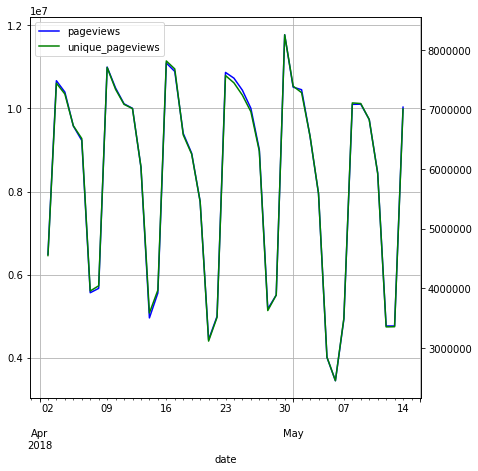

In [416]:
plt.figure(figsize=(7,7))
plt.xlabel('Date')

ax1 = grouped.plot(color='blue', label='pageviews')
ax2 = grouped_unique_pageviews.plot(color='green', grid=True, secondary_y=True, label='unique_pageviews')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()


plt.legend(h1+h2, l1+l2, loc=2)
plt.show()

In [ ]:
plot_time_metric(content_performance_bytime, 'unique_pageviews')

In [ ]:
plot_time_metric(content_performance_bytime, 'feedex_comments')

In [ ]:
plot_time_metric(content_performance_bytime, 'useful_per_responses')

In [ ]:
content_performance_bytime.columns

In [ ]:
plot_time_metric(content_performance_bytime, 'count_survey_response')

### trying to get weekday onto plot. 
Aborted for now. think ax.table might work

In [ ]:
grouped = content_performance_bytime.groupby([content_performance_bytime.index, pd.Grouper(freq='D')])['pageviews'].sum()
grouped.index = grouped.index.droplevel()


In [ ]:
grouped = grouped.to_frame()

In [ ]:
grouped['day'] = grouped.index.weekday_name

In [ ]:
grouped

In [ ]:
ax = grouped.plot()
ax.set_ylabel('Pageviews (100M)')
ax.set_xlabel('Date')
plt.show()

In [ ]:
list(zip(grouped.index, grouped.index.weekday_name))

That's a bit odd. Assumed 12/13th would be weekend but they're Thurs/Friday. 

In [ ]:
grouped.index.weekday_name

### Stratify by categorical variables

In [ ]:
def plot_time_metric_byvar(df, metric, byvar):
    grouped = df.groupby([byvar, pd.Grouper(freq='D')])[metric].sum()
    by_day = grouped.unstack(byvar, fill_value=0)
    top = by_day.iloc[:, by_day.columns.isin(by_day.min().sort_values(ascending=False)[:10].index)]
    bottom = by_day.iloc[:, by_day.columns.isin(by_day.min().sort_values()[:10].index)]
    
    ax = top.plot()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_ylabel(metric)
    ax.set_xlabel('Date')
    ax.set_title('Top 10 {}s for {}'.format(byvar, metric))
    
    ay = bottom.plot()
    ay.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ay.set_ylabel(metric)
    ay.set_xlabel('Date')
    ay.set_title('Bottom 10 {}s for {}'.format(byvar, metric))

    return ax, ay
    

In [ ]:
plot_time_metric_byvar(df=content_performance_bytime, metric='pageviews', byvar='document_type')

In [ ]:
plot_time_metric_byvar(df=content_performance_bytime, metric='unique_pageviews', byvar='document_type')

In [ ]:
plot_time_metric_byvar(df=content_performance_bytime, metric='feedex_comments', byvar='document_type')

Document types with no page views in date range

In [ ]:
#over the whole month (includes entire data range) total number of page views 

x = content_performance_bytime.groupby(['document_type', pd.Grouper(freq='M')])['pageviews'].sum()

In [ ]:
#which documen types had no page views
x[x==0]

In [ ]:
plot_time_metric_byvar(df=content_performance_bytime, metric='pageviews', byvar='primary_organisation_title')

In [ ]:
plot_time_metric_byvar(df=content_performance_bytime, metric='unique_pageviews', byvar='primary_organisation_title')

In [ ]:
plot_time_metric_byvar(df=content_performance_bytime, metric='feedex_comments', byvar='primary_organisation_title')

In [ ]:
plot_time_metric_byvar(df=content_performance_bytime, metric='pageviews', byvar='content_purpose_document_supertype')

In [ ]:
plot_time_metric_byvar(df=content_performance_bytime, metric='unique_pageviews', byvar='content_purpose_document_supertype')

In [ ]:
plot_time_metric_byvar(df=content_performance_bytime, metric='feedex_comments', byvar='content_purpose_document_supertype')

### correlation

In [ ]:
plt.matshow(content_performance_bytime.corr())

# Intrinsic content performance metrics
Explore those metrics generated by characteristics of the content itself and their correlation with metrics relating to user interaction with content.

<span style="color:red">There are multiple ids per content_id reflecting a change to the content e.g., re-written.</span>

**Need to think about left/right censoring for these items when considering date ranges**

In [ ]:
content_performance.columns

In [ ]:
def scatter_byvar(df, x, y, byvar, log=True):
    groups = df.groupby(byvar)

    # Plot
    cmap = plt.get_cmap('jet')
    colors = cmap(np.linspace(0, 1.0, len(groups)))

    fig, ax = plt.subplots()
    ax.set_prop_cycle(cycler('color', colors))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
    
    ax.set_xlabel(x)
    ax.set_title('{} and {} by {}'.format(x, y, byvar))
    
    if log:
        for name, group in groups:
            ax.plot(group[x], np.log(group[y]), marker='o', linestyle='',  label=name, alpha=0.5)
            ax.set_ylabel('log({})'.format(y))
    else:
        for name, group in groups:
            ax.plot(group[x], group[y], marker='o', linestyle='',  label=name, alpha=0.5 )
            ax.set_ylabel(y)
            
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    return ax

#### string length

In [ ]:
content_performance.string_length.describe()

In [ ]:
content_performance[content_performance['string_length']==0].shape

In [ ]:
print('{} out of {} content items ({}%) have a recorded string_length of 0'.format(
    content_performance[content_performance['string_length']==0].shape[0], 
    content_performance.content_id.nunique(),
    round(content_performance[content_performance['string_length']==0].shape[0]/content_performance.content_id.nunique()*100, 2)))

In [ ]:
content_performance.string_length.hist(bins='auto', range=(0, 7000))

In [ ]:
scatter_byvar(df=content_performance, x='string_length', y='unique_pageviews', byvar='content_purpose_document_supertype')

#### readability score
"Check readability"?!

In [ ]:
content_performance.readability_score.hist(bins='auto', range=(-750, 124))

In [ ]:
content_performance.readability_score.describe()

In [ ]:
scatter_byvar(df=content_performance, x='readability_score', y='unique_pageviews', byvar='content_purpose_document_supertype')

#### Number of pdfs

In [ ]:
content_performance.number_of_pdfs.describe()

In [ ]:
content_performance.number_of_pdfs.hist(bins=100, range=(0, 50))

In [ ]:
scatter_byvar(df=content_performance, x='number_of_pdfs', y='unique_pageviews', byvar='content_purpose_document_supertype')

#### Number of word files

In [ ]:
content_performance.number_of_word_files.describe()

In [ ]:
content_performance.number_of_word_files.hist(bins=100, range=(0, 50))

In [ ]:
scatter_byvar(df=content_performance, x='number_of_word_files', y='unique_pageviews', byvar='content_purpose_document_supertype')

#### retractions
Check apostrophe use in contractions. 
This should feed into a general ‘spelling/grammar errors’ metric.

In [ ]:
scatter_byvar(df=content_performance, x='contractions_count', y='unique_pageviews', byvar='content_purpose_document_supertype')

#### retext-equality 
- Warn about possible insensitive, inconsiderate language. This has some interesting changes (‘commit suicide’ to ‘die by suicide’, for example). Not sure how publishers would respond to this if they had lots of changes, but inclusive language should be important for us.

In [ ]:
scatter_byvar(df=content_performance, x='equality_count', y='unique_pageviews', byvar='content_purpose_document_supertype')

#### retext-indefinite-article
Check if indefinite articles (a, an) are used correctly. This should feed into a general ‘spelling/grammar errors’ metric.


In [ ]:
scatter_byvar(df=content_performance, x='indefinite_article_count', y='unique_pageviews', byvar='content_purpose_document_supertype')

In [ ]:
#scatter_byvar(df=content_performance, x='readability_score', y='unique_pageviews', byvar='document_type')

In [ ]:
scatter_byvar(df=content_performance, x='readability_score', y='unique_pageviews', byvar='content_purpose_document_supertype')

## metric by content age

In [ ]:
content_performance.columns

In [ ]:
first_published = content_performance[['first_published_at', 'pageviews', 'unique_pageviews', 'document_type', 'content_purpose_document_supertype']].copy()

In [ ]:
first_published['first_published_at'] = pd.to_datetime(first_published['first_published_at']).copy()
first_published.index = first_published['first_published_at']

In [ ]:
first_published.plot(x='first_published_at', y='pageviews', figsize=(12, 10))

Old items are generally not being viewed

In [ ]:
ax = first_published.plot(x='first_published_at', y='pageviews', figsize=(5, 3))
ax.set_xlim(pd.Timestamp('2009-12-31'), pd.Timestamp('2018-12-31'))
ax.legend_.remove()

In [ ]:
ay = first_published.plot(x='first_published_at', y='pageviews')
ay.set_xlim(pd.Timestamp('1945-12-31'), pd.Timestamp('2009-12-31'))
ay.set_ylim(0, 1000)

In [ ]:
fig, ax = plt.subplots(figsize=(5, 3))

first_published[first_published['document_type']=='guide'].plot(x='first_published_at', y='pageviews', color='DarkBlue', label='guide', style=".", ax=ax, alpha=0.5)
first_published[first_published['document_type']=='transaction'].plot(x='first_published_at', y='pageviews', color='Orange', label='transaction', style=".", ax=ax, alpha=0.8)

first_published[first_published['document_type']=='guidance'].plot(x='first_published_at', y='pageviews', color='LightBlue', label='guidance', style=".", ax=ax)
first_published[first_published['document_type']=='news_story'].plot(x='first_published_at', y='pageviews', color='Red', label='news_story', style=".", ax=ax)
first_published[first_published['document_type']=='world_news_story'].plot(x='first_published_at', y='pageviews', color='DarkGreen', label='world_news_story', style=".", ax=ax)
ax.set_xlim(pd.Timestamp('2009-12-31'), pd.Timestamp('2018-12-31'))
ax.legend_.remove()

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))

first_published[first_published['document_type']=='guide'].plot(x='first_published_at', y='pageviews', color='DarkBlue', label='guide', style=".", ax=ax, alpha=0.5)
first_published[first_published['document_type']=='transaction'].plot(x='first_published_at', y='pageviews', color='Orange', label='transaction', style=".", ax=ax, alpha=0.8)

first_published[first_published['document_type']=='guidance'].plot(x='first_published_at', y='pageviews', color='LightBlue', label='guidance', style=".", ax=ax)
first_published[first_published['document_type']=='news_story'].plot(x='first_published_at', y='pageviews', color='Red', label='news_story', style=".", ax=ax)
first_published[first_published['document_type']=='world_news_story'].plot(x='first_published_at', y='pageviews', color='DarkGreen', label='world_news_story', style=".", ax=ax)

plt.legend()

In [ ]:
groups = first_published.groupby('content_purpose_document_supertype')

In [ ]:
first_published.groupby('content_purpose_document_supertype').describe()

In [ ]:
first_published.groupby('content_purpose_document_supertype').groups['other'].min()

In [ ]:
for group in groups:
    print(min(group[1].first_published_at))

In [ ]:
first_published.index.min()

In [ ]:
# Plot
cmap = plt.get_cmap('nipy_spectral')
colors = cmap(np.linspace(0, 1.0, len(groups)))

fig, ax = plt.subplots()
ax.set_prop_cycle(cycler('color', colors))

ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    
    ax.plot(group['first_published_at'], group['pageviews'], marker='o', linestyle='', ms=5, label=name)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


plt.show()

ALERT! Cannot understand why this 1686 data is coming from. It is not showing up when I print the timestamps. how is it getting into plot ?



In [ ]:
# Plot
cmap = plt.get_cmap('nipy_spectral')
colors = cmap(np.linspace(0, 1.0, len(groups)))

fig, ax = plt.subplots()
ax.set_prop_cycle(cycler('color', colors))

ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    
    ax.plot(group['first_published_at'], group['pageviews'], marker='o', linestyle='', ms=5, label=name)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlim(pd.Timestamp('1940-12-31'), pd.Timestamp('2018-12-31'))

plt.show()

In [ ]:
# Plot
cmap = plt.get_cmap('nipy_spectral')
colors = cmap(np.linspace(0, 1.0, len(groups)))

fig, ax = plt.subplots()
ax.set_prop_cycle(cycler('color', colors))
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    
    ax.plot(group['first_published_at'], group['pageviews'], marker='o', linestyle='', ms=5, label=name)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlim(pd.Timestamp('2009-12-31'), pd.Timestamp('2018-12-31'))

plt.show()

In [ ]:
# Plot
cmap = plt.get_cmap('nipy_spectral')
colors = cmap(np.linspace(0, 1.0, len(groups)))

fig, ax = plt.subplots()
ax.set_prop_cycle(cycler('color', colors))
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    
    ax.plot(group['first_published_at'], group['pageviews'], marker='o', linestyle='', ms=5, label=name, alpha=0.8)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlim(pd.Timestamp('1945-12-31'), pd.Timestamp('2009-12-31'))
ax.set_ylim(0, 1000)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))

first_published[first_published['content_purpose_document_supertype']=='guidance'].plot(x='first_published_at', y='pageviews', color='DarkBlue', label='Guidance', style=".", ax=ax)
first_published[first_published['content_purpose_document_supertype']=='navigation'].plot(x='first_published_at', y='pageviews', color='Red', label='navigation', style=".", ax=ax)
first_published[first_published['content_purpose_document_supertype']=='transactions'].plot(x='first_published_at', y='pageviews', color='LightGreen', label='transactions', style=".", alpha=0.5, ax=ax)

plt.legend()

### pageviews by reading age

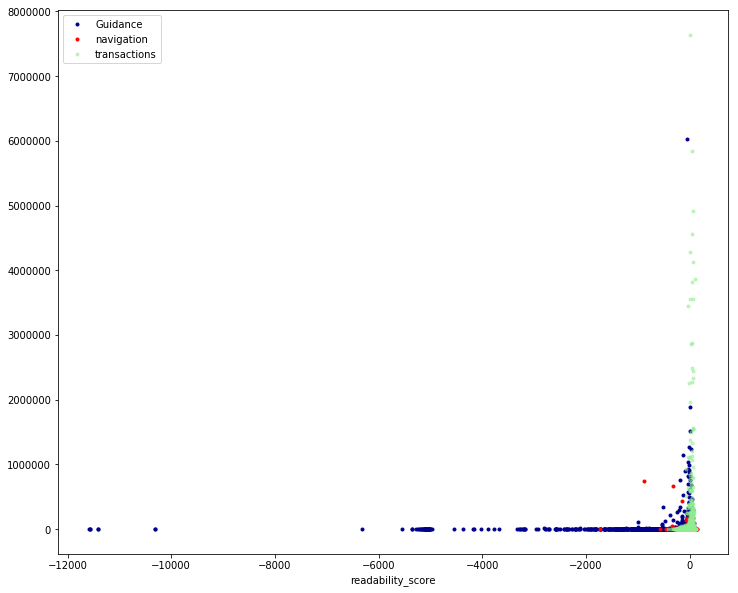

In [131]:
fig, ax = plt.subplots(figsize=(12, 10))

scatter1 = content_performance[content_performance['content_purpose_document_supertype']=='guidance'].plot(x='readability_score', y='pageviews', color='DarkBlue', label='Guidance', style=".", ax=ax)
scatter2 = content_performance[content_performance['content_purpose_document_supertype']=='navigation'].plot(x='readability_score', y='pageviews', color='Red', label='navigation', style=".", ax=ax)
scatter3 = content_performance[content_performance['content_purpose_document_supertype']=='transactions'].plot(x='readability_score', y='pageviews', color='LightGreen', label='transactions', style=".", alpha=0.5, ax=ax)

plt.legend()

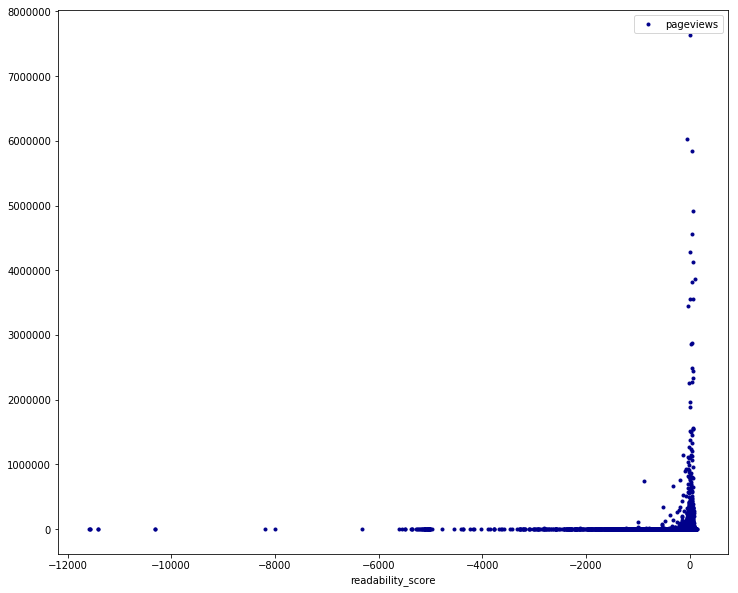

In [132]:
content_performance.plot(x='readability_score', y='pageviews', color='DarkBlue', style=".", figsize=(12, 10))



In [133]:
content_performance.readability_score.describe()

count    366564.000000
mean         14.481152
std         119.518684
min      -11595.000000
25%           7.000000
50%          26.000000
75%          43.000000
max         147.000000
Name: readability_score, dtype: float64

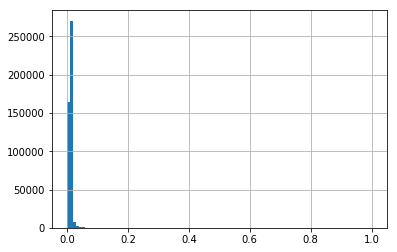

In [134]:
content_performance.readability_score_scaled.hist(bins=100)

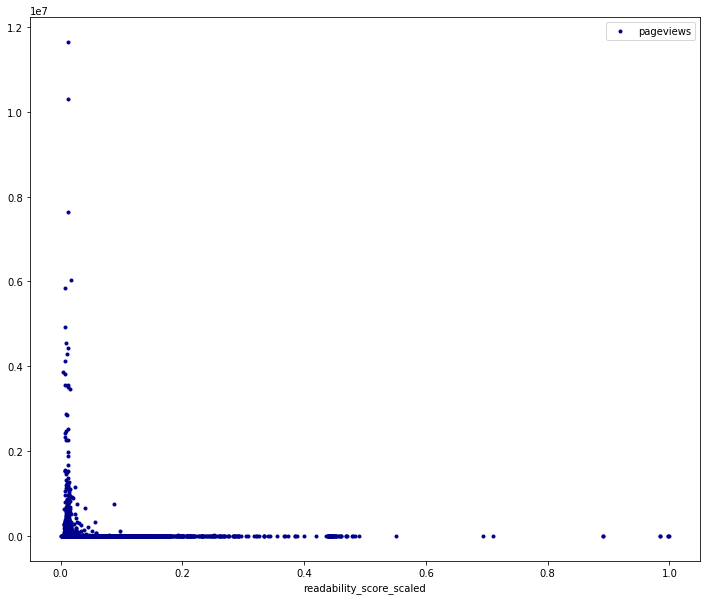

In [135]:
content_performance.plot(x='readability_score_scaled', y='pageviews', color='DarkBlue', style=".", figsize=(12, 10))



### pageviews by spelling/grammar

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 8 Text xticklabel objects>)

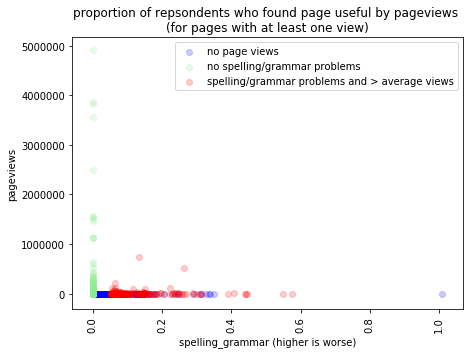

In [146]:
# content_performance.plot(x='spelling_grammar', y='pageviews', color='DarkBlue', style=".", figsize=(12, 10))

# normal values
plt.figure(figsize=(7, 5))
# plt.text(0, 0, "taxons with no content in dev set", color='red', horizontalalignment='center', 
#          verticalalignment='bottom')
plt.xlabel('spelling_grammar (higher is worse)')
plt.ylabel('pageviews')
plt.scatter(content_performance.spelling_grammar[content_performance['pageviews']==0],  
            content_performance.pageviews[content_performance['pageviews']==0], 
            c = 'b',
            alpha=0.2, 
            label='no page views'
            )
plt.scatter(content_performance.spelling_grammar[(content_performance['spelling_grammar']==0) ],  
            content_performance.pageviews[(content_performance['spelling_grammar']==0)], 
            c = 'LightGreen',
            alpha=0.2, 
            label='no spelling/grammar problems'
            )
plt.scatter(content_performance.spelling_grammar[(content_performance['spelling_grammar']>0.05) & (content_performance['pageviews']>content_performance['pageviews'].mean())],  
            content_performance.pageviews[(content_performance['spelling_grammar']>0.05)  & (content_performance['pageviews']>content_performance['pageviews'].mean())], 
            c = 'red',
            alpha=0.2, 
            label='spelling/grammar problems and > average views'
            )

plt.legend()

plt.title("pageviews by spelling/grammar problems")

plt.xticks(rotation=90)

### pageviews by usefulness rating

In [ ]:
content_performance.plot(x='useful_per_responses', y='pageviews', color='DarkBlue', style=".", figsize=(12, 10))



In [ ]:
content_performance.plot(x='useful_per_responses', y='spelling_grammar', color='DarkBlue', style=".", figsize=(12, 10))



In [ ]:
content_performance.plot(x='useful_per_responses', y='errors', color='DarkBlue', style=".", figsize=(12, 10))



In [ ]:
content_performance.plot(x='useful_per_responses', y='readability_score', color='DarkBlue', style=".", figsize=(12, 10))



### regression- GLM binomial response data

In [388]:
import statsmodels.api as sm

In [397]:
y_usefulness = accurate_proportions[['is_this_useful_yes','is_this_useful_no']].values


In [398]:
y_usefulness.shape

(575, 2)

In [399]:
x_vars = accurate_proportions[['spelling_grammar', 'errors', 'style', 'string_length', 'word_count', 'sentence_count']]

In [400]:
glm_binom = sm.GLM(y_usefulness, x_vars, family=sm.families.Binomial())
res = glm_binom.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           ['y1', 'y2']   No. Observations:                  575
Model:                            GLM   Df Residuals:                      569
Model Family:                Binomial   Df Model:                            5
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -34804.
Date:                Mon, 21 May 2018   Deviance:                       66218.
Time:                        10:56:01   Pearson chi2:                 1.05e+03
No. Iterations:                     5                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
spelling_grammar    -5.9683      0.410    -14.575      0.000      -6.771      -5.166
errors              15.7882      0

In [401]:
print("over_f = {}".format(66218/569))

over_f = 116.37609841827768


It is assumed that the residual deviance is the same as the residual degrees of freedom. If the residual deviance is larger than the residual degrees of freedom, this is called overdispersion. It means that there is extra unexplained vairation, over and above the binomial variance assumed by the model specification. 

This model is not sound, the overdisperison factor is over_f. The simplest way to take this into account is to use an 'empirical scale parameter' to reflect the fact that the errors are not binomial as well assumed but are lager than this (overdispersed) by a facotr of over_f. We refit the model using quasibinomial to account for overdispersion. 

This can't be done, obviously in statsmodels library